[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/DecisionTree.ipynb)

# Decision tree 
We want implement a decision tree for classification from scratch. For this, first we define a data-structure to represent nodes, then we define a function to pick the best *test* for a node based on a *cost function*. Starting from the root node, we use this test function recursively to find the best split until a *max-depth* is reached. Procedures closely follow our presentation in the class. This implementation is rather involved. You may find it  more difficult to follow compared to KNN implementation. 

## Initialization

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
# Set random seed for reproducibility
np.random.seed(1234)

## Data structure
We use a binary tree to assign information to the nodes of the decision tree. In particular, the instances associated with that node (`data_indices`) and the test that is used to further split that node, in the case non-leaf nodes (`split_feature, split_value`). Here, we assume each test involves a single feature, and all features are real-valued.

In [2]:
class Node:
    """
    Represents a node in the decision tree.
    
    Each node stores:
    - The data instances that fall in this node's region
    - The test (feature and threshold) used to split this node
    - Pointers to left and right children
    - Class probability distribution for predictions (used in leaf nodes)
    """
    def __init__(self, data_indices, parent):
        """
        Initialize a tree node.
        
        Parameters:
        data_indices: array of indices indicating which training samples fall in this node
        parent: reference to the parent node (None for root)
        """
        # Store indices of training data that belong to this node's region
        self.data_indices = data_indices
        
        # Children nodes (None for leaf nodes)
        self.left = None
        self.right = None
        
        # Split parameters (None for leaf nodes)
        self.split_feature = None  # Which feature to test
        self.split_value = None    # Threshold value for the test
        
        if parent:
            # Inherit properties from parent
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            
            # Compute class distribution for this node
            # np.bincount counts occurrences of each class label
            # self.labels[data_indices] selects labels for instances in this node
            # minlength ensures the array has length num_classes (even if some classes are missing)
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes)
            
            # Normalize to get probabilities
            self.class_prob = class_prob / np.sum(class_prob)
            
            # Note: For leaf nodes, class_prob is used for prediction
            # For internal nodes, it shows the class distribution before splitting

## Greedy spliting of a node
Given a node, we consider all possible feature-value combinations for splitting the data. One such **test** that produces the lowest cost according to a supplied cost function (`cost_fn`) is returned.

In [3]:
def greedy_test(node, cost_fn):
    """
    Find the best feature and threshold to split a node.
    
    This function exhaustively tests all possible splits and returns
    the one that minimizes the cost function.
    
    Parameters:
    node: the Node to split
    cost_fn: function that computes impurity of a set of labels
    
    Returns:
    best_cost: cost of the best split found
    best_feature: index of the feature for the best split
    best_value: threshold value for the best split
    """
    # Initialize best parameters
    best_cost = np.inf
    best_feature, best_value = None, None
    
    num_instances, num_features = node.data.shape
    
    # Sort data to find candidate split points
    # data_sorted has shape (num_instances_in_node, num_features)
    data_sorted = np.sort(node.data[node.data_indices], axis=0)
    
    # Candidate thresholds are midpoints between consecutive sorted values
    # data_sorted[1:] is all rows except first
    # data_sorted[:-1] is all rows except last
    # Result: test_candidates[i,f] = midpoint between i-th and (i+1)-th value for feature f
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    
    # Try splitting on each feature
    for f in range(num_features):
        # Extract the f-th feature values for instances in this node
        # data_f has shape (num_instances_in_node,)
        data_f = node.data[node.data_indices, f]
        
        # Try each candidate threshold for this feature
        for test in test_candidates[:, f]:
            # Split instances: left goes to left child, right to right child
            # data_f <= test creates boolean array
            # node.data_indices[...] selects the actual indices
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            
            # Skip invalid splits (one side would be empty)
            # Can't learn anything from such a split
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            
            # Compute impurity (cost) for each child
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            
            # Compute weighted average cost
            # Larger child has more influence on total cost
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            cost = (num_left * left_cost + num_right * right_cost) / num_instances
            
            # Update best split if this one is better
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    
    return best_cost, best_feature, best_value

## Cost functions

Below we implement two cost functions corresponding to misclassification rate and entropy.

In [4]:
def cost_misclassification(labels):
    """
    Compute misclassification cost (error rate).
    
    Cost = 1 - (probability of most common class)
    
    Lower cost means purer node (one class dominates).
    Cost of 0 means all instances have the same label (pure node).
    
    Parameters:
    labels: array of class labels for instances in a node
    
    Returns:
    cost: misclassification rate in range [0, 1-1/num_classes]
    """
    # Count occurrences of each label
    counts = np.bincount(labels)
    
    # Convert counts to probabilities
    class_probs = counts / np.sum(counts)
    # Equivalent: class_probs = np.bincount(labels) / len(labels)
    
    # Cost = 1 - max probability
    # If one class has 90% of instances, cost = 1 - 0.9 = 0.1
    return 1 - np.max(class_probs)


def cost_entropy(labels):
    """
    Compute entropy (information theory measure of impurity).
    
    Entropy = -sum(p_i * log(p_i)) for each class i
    
    Entropy is 0 for pure nodes and maximum for uniform distribution.
    Often preferred over misclassification for tree building.
    
    Parameters:
    labels: array of class labels for instances in a node
    
    Returns:
    cost: entropy value (higher means more impure/mixed)
    """
    # Compute class probabilities
    class_probs = np.bincount(labels) / len(labels)
    
    # Remove zero probabilities to avoid log(0) = -inf
    # Only keep classes that actually appear in this node
    class_probs = class_probs[class_probs > 0]
    
    # Compute entropy: -sum(p * log(p))
    return -np.sum(class_probs * np.log(class_probs))


def cost_gini_index(labels):
    """
    Compute Gini impurity (used in CART algorithm).
    
    Gini = 1 - sum(p_i^2) for each class i
    
    Gini is 0 for pure nodes and maximum for uniform distribution.
    Computationally simpler than entropy (no logarithm).
    
    Parameters:
    labels: array of class labels for instances in a node
    
    Returns:
    cost: Gini index in range [0, 1-1/num_classes]
    """
    # Compute class probabilities
    class_probs = np.bincount(labels) / len(labels)
    
    # Gini impurity: 1 - sum(p^2)
    # If all instances are one class: p=1 for that class, Gini = 1 - 1 = 0
    # If uniform over k classes: p=1/k for each, Gini = 1 - k*(1/k)^2 = (k-1)/k
    return 1 - np.sum(np.square(class_probs))

we are now ready to implement the classifier:

when to stop splitting?
1. if there are not enough points under the current node (`min_leaf_instances`)
2. if reached maximum depth (`max_depth`)
3. if the decrease in the cost is negligible (not implemented)
Below is the template for the class, next we implement `fit` and `predict` methods.

In [5]:
class DecisionTree:
    """
    Decision Tree classifier for multi-class classification.
    
    Builds a binary tree by recursively splitting nodes using the best
    feature-threshold combination according to a cost function.
    
    Stopping criteria:
    1. Maximum depth reached
    2. Too few instances in node (min_leaf_instances)
    3. No valid split exists (would create empty child)
    """
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        """
        Initialize Decision Tree classifier.
        
        Parameters:
        num_classes: number of classes (inferred from labels if None)
        max_depth: maximum depth of tree (controls overfitting)
        cost_fn: function to measure node impurity (entropy, gini, or misclassification)
        min_leaf_instances: minimum samples required to be in a leaf node
        """
        self.max_depth = max_depth
        self.root = None  # Will be set during fit()
        self.cost_fn = cost_fn
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances
        
    def fit(self, data, labels):
        """Fit the decision tree to training data."""
        pass  # Implemented below
    
    def predict(self, data_test):
        """Predict class probabilities for test data."""
        pass  # Implemented below

## Fit
To fit the tree to the data, we call the `_fit_tree` method on the `root_node` of the tree. In this method the _best_ test (split) for the current node is found, and the method is recursively called on the left and right child. If the `max_depth` is reached or the number of instances under the current node is below `min_leaf_instances` the node is not split anymore, resulting in a leaf node.

In [6]:
def fit(self, data, labels):
    """
    Build the decision tree from training data.
    
    Parameters:
    data: training features, shape (N, D)
    labels: training labels, shape (N,)
    
    Returns:
    self: fitted classifier
    """
    self.data = data
    self.labels = labels
    
    # Infer number of classes if not specified
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    
    # Initialize root node with all training data
    # np.arange(data.shape[0]) creates array [0, 1, 2, ..., N-1]
    self.root = Node(np.arange(data.shape[0]), None)
    
    # Set root properties (no parent, so set manually)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    
    # Recursively build the tree starting from root
    self._fit_tree(self.root)
    
    return self


def _fit_tree(self, node):
    """
    Recursively build the tree by splitting nodes.
    
    This is the core tree-building algorithm:
    1. Check stopping criteria
    2. Find best split for current node
    3. Create left and right children
    4. Recursively fit children
    
    Parameters:
    node: current node to potentially split
    """
    # Stopping criteria: reached max depth or too few instances
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        # Don't split - this becomes a leaf node
        return
    
    # Find the best test (feature and threshold) to split this node
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    
    # If no valid split exists (cost is infinity), make this a leaf
    # This happens when all splits would create an empty child
    if np.isinf(cost):
        return
    
    # Store the split parameters in this node
    node.split_feature = split_feature
    node.split_value = split_value
    
    # Create boolean mask: True for instances going to left child
    # node.data[node.data_indices, split_feature] gets the feature values
    test = node.data[node.data_indices, split_feature] <= split_value
    
    # Create left child (instances satisfying the test)
    # node.data_indices[test] selects indices where test is True
    left = Node(node.data_indices[test], node)
    
    # Create right child (instances not satisfying the test)
    # np.logical_not(test) inverts the boolean array
    right = Node(node.data_indices[np.logical_not(test)], node)
    
    # Recursively build left and right subtrees
    self._fit_tree(left)
    self._fit_tree(right)
    
    # Attach children to current node
    node.left = left
    node.right = right


# Attach methods to the DecisionTree class
DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

## New predictions
Given a new instance, starting from the `root` of the `DecisionTree` we check to see if the instance falls in the left or right split, and repeat the process with left or right node depending on the test, until we reach a leaf node. The class probabilities of the training data under the leaf is returned.

In [7]:
def predict(self, data_test):
    """
    Predict class probabilities for test instances.
    
    For each test instance:
    1. Start at root
    2. Follow splits based on feature values
    3. When reaching a leaf, return its class probabilities
    
    Parameters:
    data_test: test features, shape (N_test, D)
    
    Returns:
    class_probs: predicted class probabilities, shape (N_test, num_classes)
    """
    # Initialize output array
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    
    # Process each test instance
    for n, x in enumerate(data_test):
        # Start at root
        node = self.root
        
        # Traverse tree until reaching a leaf
        # Leaf nodes have node.left = None
        while node.left:
            # Check the split condition
            if x[node.split_feature] <= node.split_value:
                # Go left
                node = node.left
            else:
                # Go right
                node = node.right
        
        # Reached a leaf - use its class distribution for prediction
        class_probs[n, :] = node.class_prob
    
    return class_probs


# Attach method to the DecisionTree class
DecisionTree.predict = predict

# Experiments
For more information on visualizing the model's performace on the data and its decision boundry go through the experiment section of the KNN code or watch the coding tutorial on KNN. 
We conveniently load the dataset from the sklearn collection of datasets

In [8]:
from sklearn import datasets

# Load Iris dataset
dataset = datasets.load_iris()

# Use only first 2 features (sepal length and width) for 2D visualization
# x has shape (150, 2), y has shape (150,)
x, y = dataset['data'][:, :2], dataset['target']

# Get dataset dimensions
(num_instances, num_features), num_classes = x.shape, np.max(y) + 1

# Randomly shuffle instance indices for train-test split
inds = np.random.permutation(num_instances)

# Split: first 100 instances for training, rest for testing
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

next we fit the tree to the training data and predict on the test data. 

accuracy is 64.0%.


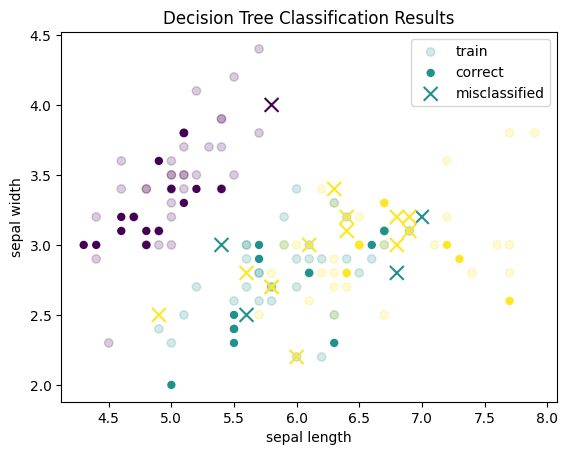

In [9]:
# Train decision tree with maximum depth of 20
tree = DecisionTree(max_depth=20)
probs_test = tree.fit(x_train, y_train).predict(x_test)

# Convert probabilities to class predictions
# np.argmax(probs_test, 1) finds the class with highest probability for each instance
# axis=1 means find max along columns (across classes)
y_pred = np.argmax(probs_test, 1)

# Compute accuracy
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}%.')

# Visualization
# Identify correctly and incorrectly classified instances
correct = y_test == y_pred
incorrect = np.logical_not(correct)

# Plot training data (semi-transparent)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker='o', alpha=.2, label='train')

# Plot correctly classified test instances (dots)
plt.scatter(x_test[correct, 0], x_test[correct, 1], marker='.', c=y_pred[correct], s=100, label='correct')

# Plot misclassified test instances (X marks)
plt.scatter(x_test[incorrect, 0], x_test[incorrect, 1], marker='x', c=y_test[incorrect], s=100, label='misclassified')

plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()
plt.title('Decision Tree Classification Results')
plt.show()

We then plot the *decision boundary*

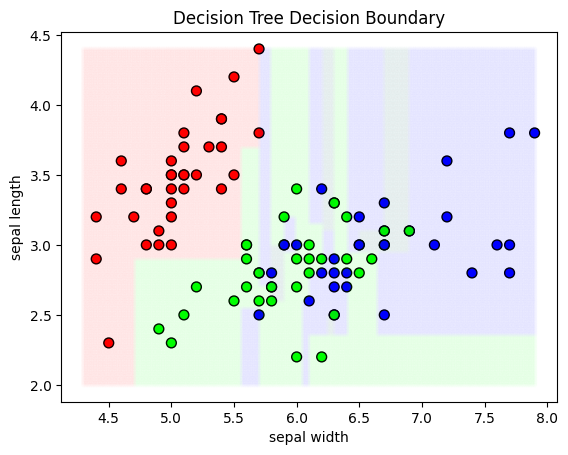

In [10]:
# Create a dense grid to visualize decision boundary
# Generate 200 evenly spaced values for each feature
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)

# Create 2D mesh grid
# x0 and x1 are both (200, 200) arrays
x0, x1 = np.meshgrid(x0v, x1v)

# Flatten and combine into array of all grid points
# ravel() flattens (200, 200) -> (40000,)
# vstack stacks vertically, then transpose: (2, 40000) -> (40000, 2)
# Each row is a point [x0, x1] in the feature space
x_all = np.vstack((x0.ravel(), x1.ravel())).T

# Train a deep tree (max_depth=200) to show detailed decision boundary
model = DecisionTree(max_depth=200)

# Create one-hot encoded probabilities for training labels
# y_train_prob[i, y_train[i]] = 1, all other entries are 0
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

# Predict probabilities for all grid points
y_prob_all = model.fit(x_train, y_train).predict(x_all)

# Plot training data (opaque, using one-hot encoding for colors)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_prob, marker='o', alpha=1, s=50, edgecolors='black')

# Plot decision boundary (very transparent grid points colored by prediction)
# The regions show which class the tree predicts in each area
plt.scatter(x_all[:, 0], x_all[:, 1], c=y_prob_all, marker='.', alpha=.01)

plt.xlabel('sepal width')
plt.ylabel('sepal length')
plt.title('Decision Tree Decision Boundary')
plt.show()